In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Original Image')

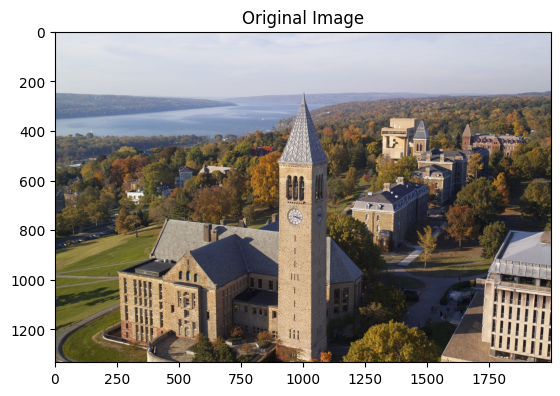

In [25]:
img = cv2.imread('original_img.jpg')
if img is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert the image from BGR to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
# Pixels is a 2D array with a shape of (total_number_of_pixels, 3)
# Each row represents a pixel the 3 columns contain the RGB values
pixels = img.reshape((-1, 3)).astype(np.float32)

plt.imshow(img)
plt.title("Original Image")


Image Compression with K-Means Clustering

Identifies the k most representative colors and replaces the RGB value of all pixels to match one of those colors.

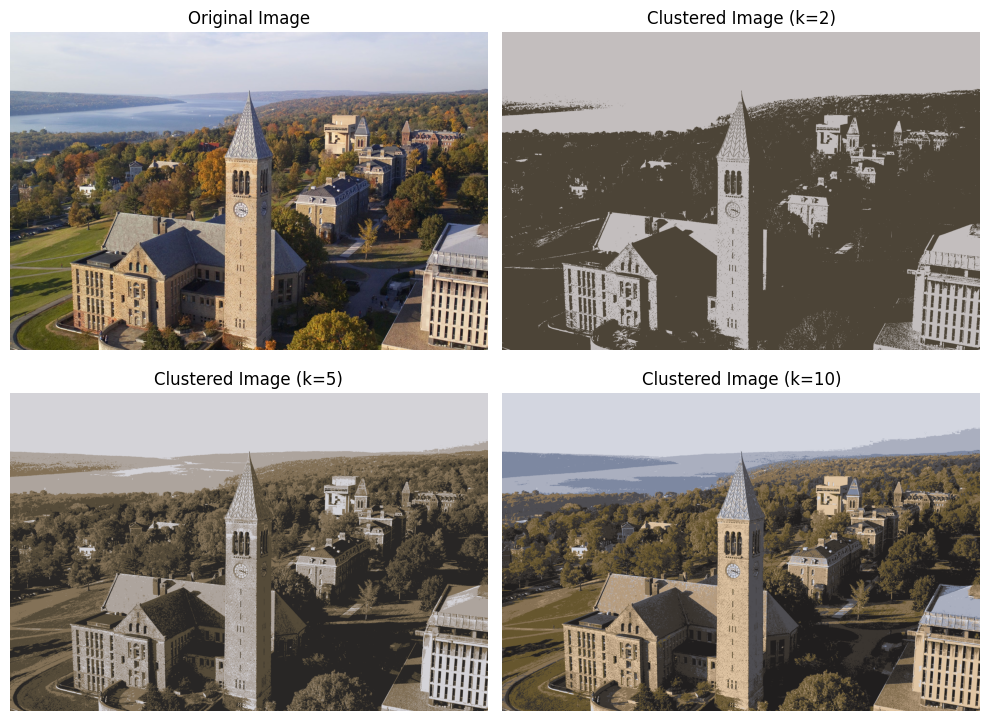

In [ ]:
# This cell displays the original image and 3 clustered images in a 2x2 grid

plt.figure(figsize=(10, 7.5))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

k_values = [2, 5, 10]
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
    kmeans.fit(pixels)

    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    clustered_img = cluster_centers[labels].reshape(img.shape).astype(np.uint8)


    plt.subplot(2, 2, i + 2) 
    plt.imshow(clustered_img)
    plt.title(f"Clustered Image (k={k})")
    plt.axis('off')

plt.tight_layout()
plt.show()

Edge Detection with Sobel Filters

Calculates the gradient of an image's intensity at each pixel, using two 3x3 convolution kernels to detect changes in the horizontal and vertical directions to highlight edges

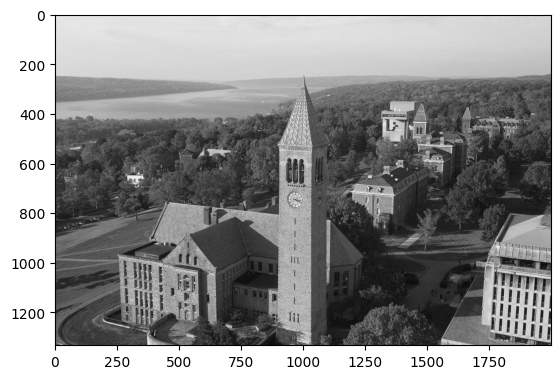

In [ ]:
# grayscale image to prepare for edge detection
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
plt.imshow(gray_img,cmap='gray')              

In [10]:
def sobel_filters(img):
    PAD_SIZE = 1 #Kernel is 3 x 3, so the pad_size is 1
    img = np.pad(img, PAD_SIZE) #Pad image, so we take a kernel mask of the borders

    Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) #Detect edges in x direction
    Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) #Detect edges in y direction

    row, col = img.shape

    output_img = np.zeros((row - 2 * PAD_SIZE, col - 2 * PAD_SIZE)) #Output image should be the orignal image size without padding


    for i in range(PAD_SIZE, row - PAD_SIZE):
        for j in range(PAD_SIZE, col - PAD_SIZE):
            kernel = img[i - PAD_SIZE:i + PAD_SIZE + 1, j - PAD_SIZE:j + PAD_SIZE + 1]
            Ix = np.sum(kernel * Kx)
            Iy = np.sum(kernel * Ky)
            G = np.hypot(Ix,Iy) #Combine our detection in the x and y directions by finding the square root of the sum of the squares 
            output_img[i - PAD_SIZE, j - PAD_SIZE] = G
    return output_img

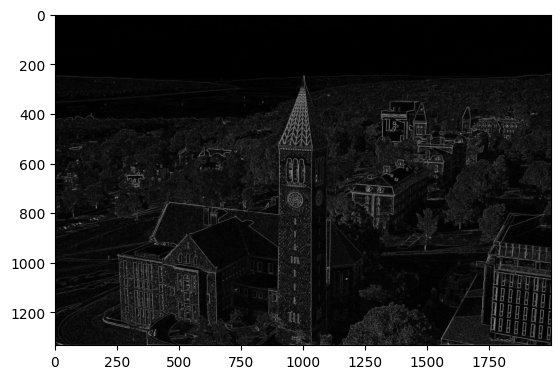

In [14]:
edge_dectected = sobel_filters(gray_img)
plt.imshow(edge_dectected, cmap='gray')
plt.imsave('edge_detected_img.png', edge_dectected, cmap='gray')

Reduce Salt and Pepper Noise with Median Filtering

Salt and pepper noise is a type of image noise where certain pixels are randomly corrupted with white and black values. To simulate this noise, we randomly replace some pixels in the image with either pure white or pure black. 

Then, to reduce this noise, we apply a **3 × 3 median filter**. This works by replacing each pixel with the median value of its 3 × 3 neighborhood. Since the median operation circumvents extreme values (such as the black and white noise pixels), it effectively reduces the noise. 

In [16]:
# add salt and pepper noise to a RGB image
def add_noise(img):
    #Make a copy of the image because original image-array is read-only
    #We need to write the array to change some pixels to white or black
    img = np.array(img, copy=True)
    
    row,col,channels = img.shape
    num_pix = int(5*1e5) #change this to a reasonable value for the resolution of your image
    #Randomly change num_pix pixels to white
    for i in range(num_pix):
        y_coord = random.randint(0,row-1)
        x_coord = random.randint(0,col-1)
        img[y_coord][x_coord] = [255, 255, 255]  
    #Randomly change num_pix pixels to black
    for i in range(num_pix):
        y_coord = random.randint(0,row-1)
        x_coord = random.randint(0,col-1)
        img[y_coord][x_coord] = [0,0,0]
        
    return img

Text(0.5, 1.0, 'Image with Salt and Pepper Noise')

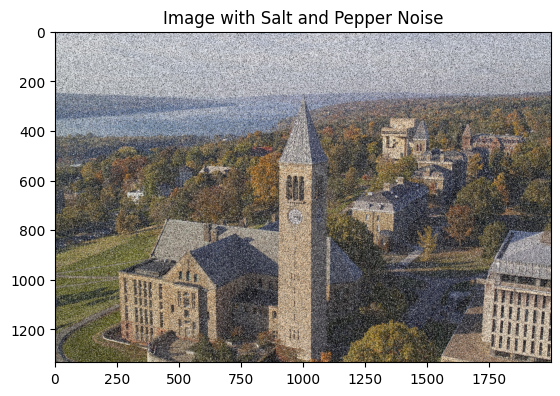

In [24]:
# add salt and pepper noise to image
noise_img = add_noise(img)
noise_img.flags.writeable = False
plt.imshow(noise_img)
plt.title("Image with Salt and Pepper Noise")

I show a manual implementation of median filtering, but practically, use cv2.medianBlur(). 

In [26]:
def find_median(arr):
    # We are passing a kernel in for the argument which is a 2D NP array, so flatten it first
    arr = arr.flatten()  
    arr.sort() 
    n = len(arr)
    # For an even length array, return the average of the two middle values
    if n % 2 == 0:
        return (arr[n // 2] + arr[n // 2 - 1]) // 2
    # For an odd length array, return the middle value 
    return arr[n // 2] 

def median_filter(img, kernel_size):
    pad_size = kernel_size // 2

    # Pad image so we can apply kernel to borders
    img = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)

    row, col, num_channels = img.shape

    output_img = np.zeros((row - 2 * pad_size, col - 2 * pad_size, num_channels), dtype=img.dtype)

    # For each of the three channels (B, G, R), replace each pixel in the output image
    # with the median of the pixel values in the kernel centered at the pixel we are replacing
    for c in range(num_channels):
        for i in range(pad_size, row - pad_size):
            for j in range(pad_size, col - pad_size):
                kernel = img[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1, c]
                output_img[i - pad_size, j - pad_size, c] = find_median(kernel)

    return output_img


Text(0.5, 1.0, 'Image After Median Filtering')

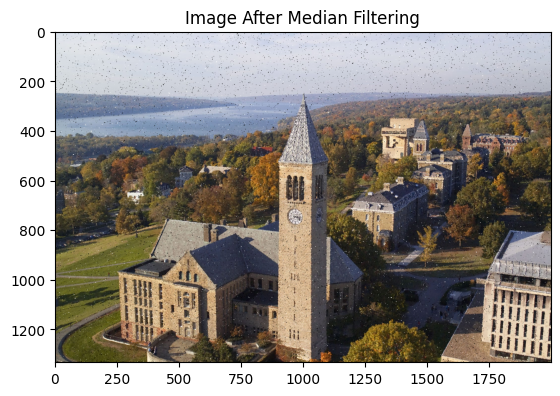

In [27]:
filtered = median_filter(noise_img,3)
plt.imshow(filtered)
plt.title("Image After Median Filtering")

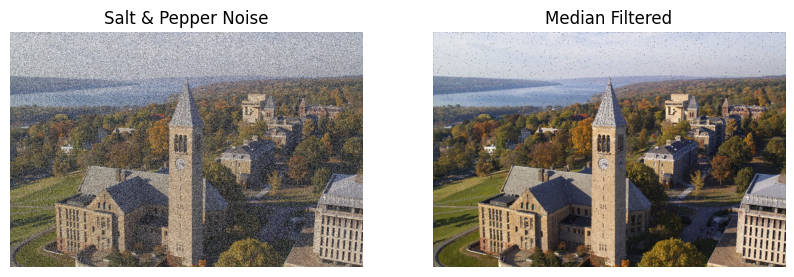

In [30]:
# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the noisy image
axes[0].imshow(noise_img, cmap='gray')
axes[0].set_title("Salt & Pepper Noise")
axes[0].axis("off")

# Show the filtered image
axes[1].imshow(filtered, cmap='gray')
axes[1].set_title("Median Filtered")
axes[1].axis("off")

# Save the figure
plt.savefig("reducing_salt_pepper_noise.png", dpi=300, bbox_inches='tight')